# Demostración de Árboles de Decisión
## Data Mining - Doctorado UDP 2024
**Bastián González-Bustamante** \
Octubre 2024

## PASO 1: Importar paquetes

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn import tree
import wbgapi as wb

## PASO 2: Obtener datos

In [32]:
## Indicadores: PIB, Población y Tasa de mortalidad infantil
indicadores = ["NY.GDP.MKTP.CD",  # PIB (USD)
               "SP.POP.TOTL",      # Población total
               "SP.DYN.IMRT.IN"]   # Tasa de mortalidad infantil (por 1,000 nacidos vivos)

## Descargar datos para el periodo 2010-2020
datos_wb = wb.data.DataFrame(indicadores, time=range(2010, 2021), labels=True)

In [33]:
## Filtrar para algunos países específicos
paises = ["United States", "Argentina", "Brazil", "Chile", "Mexico", "Francia", "China", "India"]
datos_wb = datos_wb[datos_wb['Country'].isin(paises)]

In [36]:
## Pivotear la tabla para tener los años como filas en lugar de columnas
datos_wb = datos_wb.melt(id_vars=["Country", "Series"], var_name="year", value_name="value")

In [37]:
## Convertir años a formato numérico y filtrar entre 2010 y 2020
datos_wb["year"] = datos_wb["year"].str.extract('(\d+)').astype(int)
datos_wb = datos_wb[(datos_wb["year"] >= 2010) & (datos_wb["year"] <= 2020)]

In [38]:
## Pivotear las series para que cada indicador sea una columna
datos_wb_pivot = datos_wb.pivot_table(index=["Country", "year"], columns="Series", values="value").reset_index()

In [39]:
## Renombrar las columnas para que sean más legibles
datos_wb_pivot.columns = ["pais", "anio", "pib", "poblacion", "mortalidad_infantil"]

In [41]:
## Eliminar filas con valores NA
datos_limpios = datos_wb_pivot.dropna()

In [42]:
## Inspección
print(datos_wb.head())

         Country             Series  year         value
0  United States  GDP (current US$)  2010  1.504897e+13
1         Mexico  GDP (current US$)  2010  1.105424e+12
2          India  GDP (current US$)  2010  1.675616e+12
3          China  GDP (current US$)  2010  6.087192e+12
4          Chile  GDP (current US$)  2010  2.170512e+11


## PASO 3: Preparar datos para el modelo

In [43]:
## Seleccionar solo algunas variables para el análisis
datos_modelo = datos_limpios[["pib", "poblacion", "mortalidad_infantil"]]

In [44]:
## Log-transformación de PIB y población
X = np.log(datos_modelo[["pib", "poblacion"]])
y = datos_modelo["mortalidad_infantil"]

## PASO 4: Crear árbol de decisión

In [48]:
modelo_arbol = DecisionTreeRegressor()
modelo_arbol.fit(X, y)

DecisionTreeRegressor()

In [49]:
## Resumen del modelo (Importancia de características)
print(modelo_arbol.feature_importances_)

[0.7209429 0.2790571]


## PASO 6: Visualizar árbol

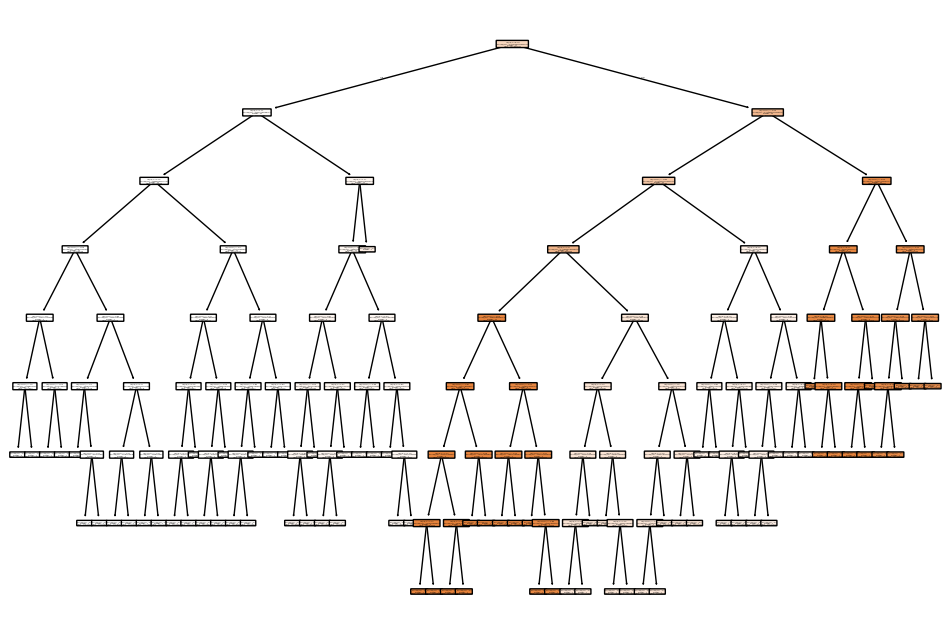

In [50]:
plt.figure(figsize=(12, 8))
tree.plot_tree(modelo_arbol, feature_names=["log(pib)", "log(poblacion)"], filled=True, rounded=True)
plt.show()

## PASO 7: Predecir con el modelo

In [51]:
nuevos_datos = pd.DataFrame({"pib": [np.log(1e12), np.log(5e11)], 
                             "poblacion": [np.log(300000000), np.log(150000000)]})
predicciones = modelo_arbol.predict(nuevos_datos)

In [52]:
## Predicciones
print(predicciones)

[1.12532401e+08 4.12614900e+07]


## PASO 8: Aplicar diferentes criterios de división

In [53]:
## Árbol con el criterio Gini
modelo_gini = DecisionTreeClassifier(criterion="gini")
modelo_gini.fit(X, y)

DecisionTreeClassifier()

In [54]:
## Árbol con el criterio de entropía (deviance)
modelo_entropy = DecisionTreeClassifier(criterion="entropy")
modelo_entropy.fit(X, y)

DecisionTreeClassifier(criterion='entropy')

## PASO 9: Poda del árbol de decisión

In [55]:
path = modelo_arbol.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [56]:
## Elegir el valor de ccp_alpha mínimo que da el error más bajo
ccp_alpha_optimo = ccp_alphas[np.argmin(impurities)]

In [57]:
## Crear el árbol podado usando el valor óptimo de ccp_alpha
modelo_podado = DecisionTreeRegressor(ccp_alpha=ccp_alpha_optimo)
modelo_podado.fit(X, y)

DecisionTreeRegressor(ccp_alpha=np.float64(0.0))

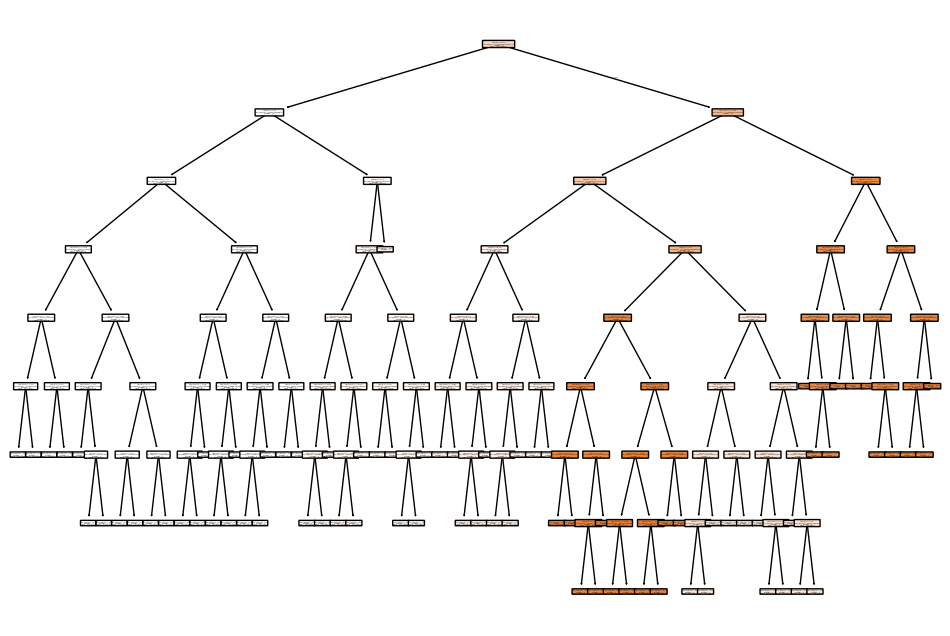

In [58]:
## Visualizar el árbol podado
plt.figure(figsize=(12, 8))
tree.plot_tree(modelo_podado, feature_names=["log(pib)", "log(poblacion)"], filled=True, rounded=True)
plt.show()

## PASO 10: Validación cruzada

In [59]:
scores = cross_val_score(modelo_arbol, X, y, cv=10)
print(f'Cross-validated scores: {scores}')

Cross-validated scores: [  -4.1377132  -142.57847128    0.84109149   -3.98411433    0.99378532
 -202.36455197    0.975528     -0.46689529  -39.49265342   -4.42222896]
